# Bank Customer Segmentation (Portfolio Project)

Recent research in customer segmentation for banking emphasizes the integration of profitability, not just behavior, into RFM (Recency, Frequency, Monetary) analysis. The approach goes beyond traditional customer clustering by linking segment profiles directly to financial value—enabling banks to identify, understand, and prioritize their highest-value customer segments, as well as adapt strategies for lower-value or at-risk groups. The best-performing segments (“Best Customers”) often make up a small proportion of the customer base but contribute a disproportionately large share of revenue, while strategic attention may also be needed for “Spenders” (low frequency, high value) or “Uncertain Customers” (low frequency, low value). This project ustilises a Kaggle Dataset containing over 1M transaction by over 800K customers for a bank in India. By using K-Means Clustering (an unsupervised machine learning algorithm) to group customers into 4 segments, it provides insights on how to target the customers with most business values that enhances the business revenue.

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import kruskal
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score

from scipy.stats import chi2_contingency
import shap

## Load data and EDA

First, it is to load the dataset and take a glimpse on the data.

In [2]:
file_path = 'bank_transactions.csv'
df = pd.read_csv(file_path)

In [3]:
# View top 5 rows
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [4]:
# Summary statistics
print(df.describe())

       CustAccountBalance  TransactionTime  TransactionAmount (INR)
count        1.046198e+06     1.048567e+06             1.048567e+06
mean         1.154035e+05     1.570875e+05             1.574335e+03
std          8.464854e+05     5.126185e+04             6.574743e+03
min          0.000000e+00     0.000000e+00             0.000000e+00
25%          4.721760e+03     1.240300e+05             1.610000e+02
50%          1.679218e+04     1.642260e+05             4.590300e+02
75%          5.765736e+04     2.000100e+05             1.200000e+03
max          1.150355e+08     2.359590e+05             1.560035e+06


In [5]:
# Check for missing values
print(df.isnull().sum())

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64


Since there are some missing data, with the large dataset I have here, I decide to drop the data with NA for better analysis and modelling.

In [6]:
df.dropna(axis=0, inplace=True)
print(df.isnull().sum())

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64


In [7]:
# Data types overview
print(df.dtypes)

TransactionID               object
CustomerID                  object
CustomerDOB                 object
CustGender                  object
CustLocation                object
CustAccountBalance         float64
TransactionDate             object
TransactionTime              int64
TransactionAmount (INR)    float64
dtype: object


'CustomerDOB' and 'TransactionDate' should be converted to datetime format to correctly represent their features.

In [8]:
# Convert 'CustomerDOB' and 'TransactionDate' to datetime
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], format='%d/%m/%y', errors='coerce')
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%d/%m/%y', errors='coerce')

In [9]:
df['CustGender'].value_counts()

CustGender
M    760978
F    280635
T         1
Name: count, dtype: int64

Since 'T' (possibily transgender in this context) appears only once in the dataset, it is an extremely rare case. To simplify the analysis and modelling process without greatly affecting overall performance, this data entry will be dropped to ensure the quality and robustness of the analysis.

In [10]:
df.drop(df[df['CustGender'] == 'T'].index, inplace=True)

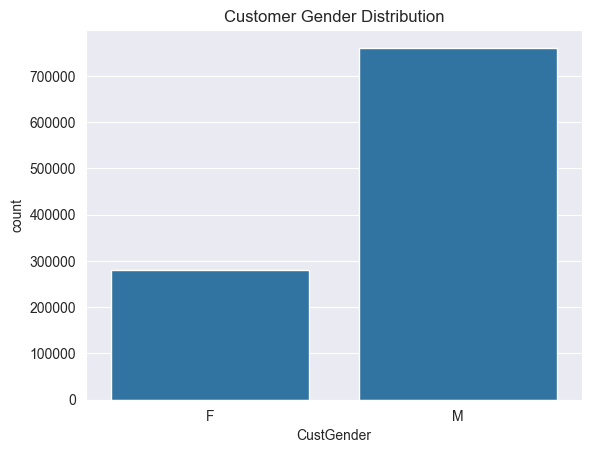

In [11]:
# Distribution of Customer Gender
sns.countplot(data=df, x='CustGender')
plt.title('Customer Gender Distribution')
plt.show()

The plot shows that there are much more male customers than females in the dataset. Therefore, gender could be a key variable in the dataset, with practical implications for personalized marketing and fairness—in clustering, ensure segments accurately reflect this demographic split and consider if underrepresented groups require special analytical handling.

In [12]:
df['CustLocation'].value_counts()

CustLocation
MUMBAI                            101997
NEW DELHI                          84143
BANGALORE                          81330
GURGAON                            73594
DELHI                              70549
                                   ...  
DISTRICT PURI                          1
DHAKOLA                                1
KANDESHWAR STATION NAVI MUMBAI         1
HOSHIAR PUR                            1
IMPERIA THANE WEST                     1
Name: count, Length: 9275, dtype: int64

In [13]:
location_counts = df['CustLocation'].value_counts()
total_customers = len(df)

# Compute cumulative sum of customer counts sorted by top locations
cumulative_pct = location_counts.cumsum() / total_customers * 100

# Print coverage for top 10, 15, 20 locations
for n in [10, 15, 20]:
    print(f"Top {n} locations cover: {cumulative_pct.iloc[n-1]:.2f}% of customers")

Top 10 locations cover: 52.24% of customers
Top 15 locations cover: 59.14% of customers
Top 20 locations cover: 62.93% of customers


Since there are too many locations in the dataset (>9000). When the top 15 locations cover about 60% of all customers, which is a substantial share of the customer base, the analysis will group the remaining lower-frequency locations into a single 'Other' category to keep the feature space manageable and robust for machine learning.  

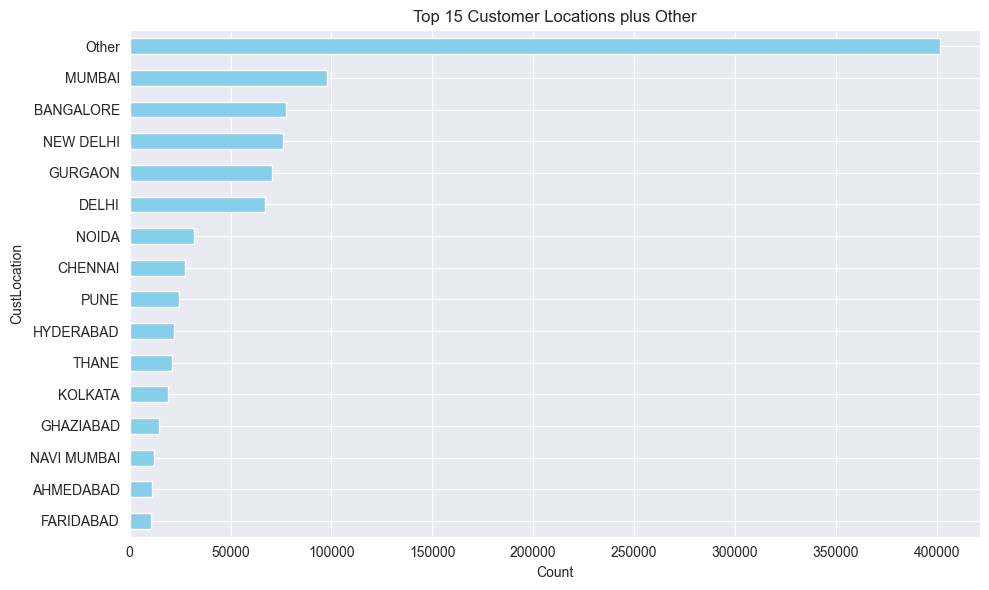

In [61]:
# Compute and plot top 15 locations by count
top_15_locations = df['CustLocation'].value_counts().nlargest(15).index
df['Top15Location'] = df['CustLocation'].where(df['CustLocation'].isin(top_15_locations), 'Other')

top_15_location_counts = df['Top15Location'].value_counts().sort_values()

plt.figure(figsize=(10,6))
top_15_location_counts.plot(kind='barh', color='skyblue')
plt.title('Top 15 Customer Locations plus Other')
plt.xlabel('Count')
plt.ylabel('CustLocation')
plt.tight_layout()
plt.show()

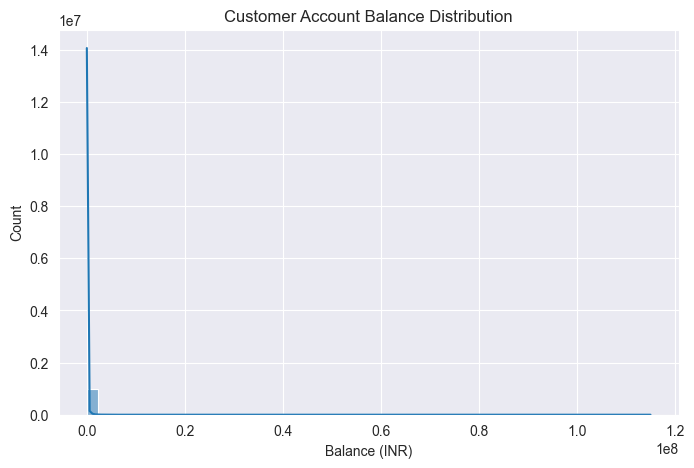

In [64]:
# Histogram of Customer Account Balance
plt.figure(figsize=(8, 5))
sns.histplot(df['CustAccountBalance'], bins=50, kde=True)
plt.title('Customer Account Balance Distribution')
plt.xlabel('Balance (INR)')
plt.ylabel('Count')
plt.show()

Account Blance is heavily skewed (most accounts have very small balance), it is better to log-transform the feature to have a better view. 

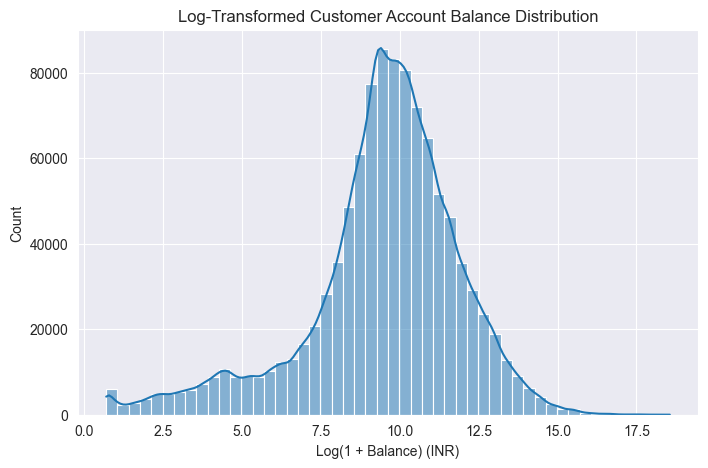

In [16]:
# Histogram of Customer Account Balance (log-transformed)
df['log_balance'] = np.log1p(df['CustAccountBalance'] + 1)

plt.figure(figsize=(8, 5))
sns.histplot(df['log_balance'], bins=50, kde=True)
plt.title('Log-Transformed Customer Account Balance Distribution')
plt.xlabel('Log(1 + Balance) (INR)')
plt.ylabel('Count')
plt.show()

The log-transformed cusomter account balance distribution is close to normal distribution. Similarlly, Transaction amount is log-transformed. 

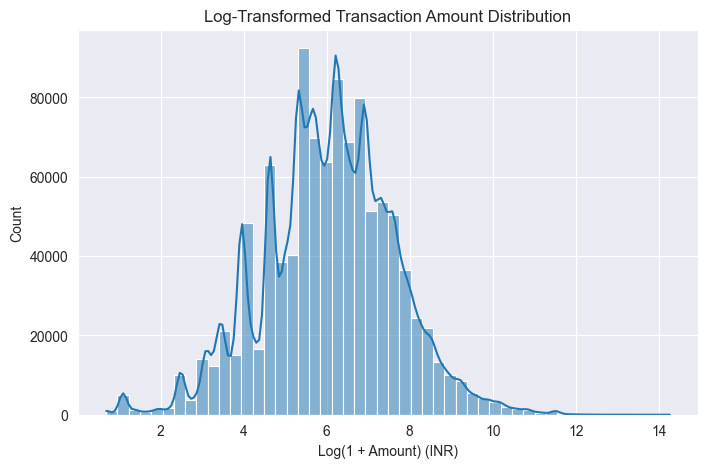

In [17]:
# Histogram of Transaction Amounts (log-transformed)
df['log_amount'] = np.log1p(df['TransactionAmount (INR)'] +1)

plt.figure(figsize=(8, 5))
sns.histplot(df['log_amount'], bins=50, kde=True)
plt.title('Log-Transformed Transaction Amount Distribution')
plt.xlabel('Log(1 + Amount) (INR)')
plt.ylabel('Count')
plt.show()

In [18]:
# Additional: Analyze customer age if needed
if 'CustomerDOB' in df.columns:
    current_date = pd.to_datetime('today').normalize()
    df.loc[df['CustomerDOB'] > current_date, 'CustomerDOB'] -= pd.DateOffset(years=100)
    df['Age'] = (current_date - df['CustomerDOB']).dt.days // 365

df['Age'].describe()

count    985322.000000
mean         39.831161
std           8.759437
min           0.000000
25%          34.000000
50%          38.000000
75%          43.000000
max          99.000000
Name: Age, dtype: float64

Age values below 18 and above 90 as they are likely data errors and not representative of the target banking population. So, in this project, I will take away them to enhance a more robust analysis. 

In [19]:
df = df[(df['Age'] >= 18) & (df['Age'] <= 90)]

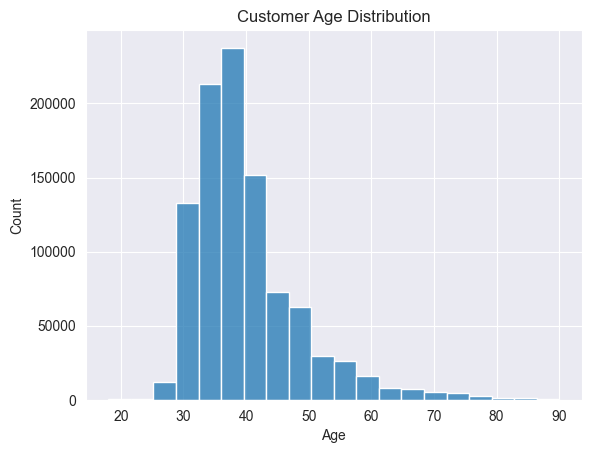

In [20]:
sns.histplot(df['Age'], bins=20)
plt.title('Customer Age Distribution')
plt.xlabel('Age')
plt.show()

## Data Preprocessing & Feature Engineering

In [21]:
# Group transactions by CustomerID to get aggregate behavioral and value metrics
customer_report = df.groupby('CustomerID').agg({
    'TransactionAmount (INR)': ['sum', 'mean', 'count'],
    'CustAccountBalance': 'last',
    'TransactionDate': ['min', 'max']
})
customer_report.columns = ['TotalTransSum', 'AvgTransAmount', 'TransCount', 'EndBalance', 'FirstTrans', 'LastTrans']

In [22]:
customer_report['Log_TotalTransSum'] = np.log1p(customer_report['TotalTransSum'])
customer_report['Log_AvgTransAmount'] = np.log1p(customer_report['AvgTransAmount'])
customer_report['Log_EndBalance'] = np.log1p(customer_report['EndBalance'])

customer_report['RecencyDays'] = (pd.to_datetime('today') - customer_report['LastTrans']).dt.days
customer_report.reset_index(inplace=True)

In [23]:
features = ['Log_TotalTransSum', 'Log_AvgTransAmount', 'TransCount', 'Log_EndBalance', 'RecencyDays']
scaler = RobustScaler()
X_scaled = scaler.fit_transform(customer_report[features])

Customer Segmentation using K-means Clustering

According to the article,  K-means clustering is the most frequently used algorithm. Moreover, on average, researchers create 5.7 customer segments per study (SD=3.9, Mode=4, Median=5). Therefore, in this project, I use K-means clustering with 4 segments as the most common approach in customer segmentation.

In [24]:
kmeans = KMeans(n_clusters=4, random_state=42)
customer_report['Segment'] = kmeans.fit_predict(X_scaled)

In [25]:
segment_profile = customer_report.groupby('Segment').agg({
    'CustomerID': 'count',
    'TotalTransSum': 'sum',
    'AvgTransAmount': 'mean',
    'EndBalance': 'mean'
}).rename(columns={'CustomerID': 'NumOfCustomers'})

# Calculate percentage revenue/profit per segment
total_revenue = segment_profile['TotalTransSum'].sum()
segment_profile['RevenuePct'] = 100 * segment_profile['TotalTransSum'] / total_revenue

print(segment_profile)

         NumOfCustomers  TotalTransSum  AvgTransAmount     EndBalance  \
Segment                                                                 
0                231385   1.146041e+09     4193.875822  228902.678497   
1                359981   1.857673e+08      461.943159   77088.697022   
2                148792   9.890596e+06       64.467939   46192.802503   
3                 98428   8.684481e+07      724.731447     261.786160   

         RevenuePct  
Segment              
0         80.224432  
1         13.003959  
2          0.692355  
3          6.079254  


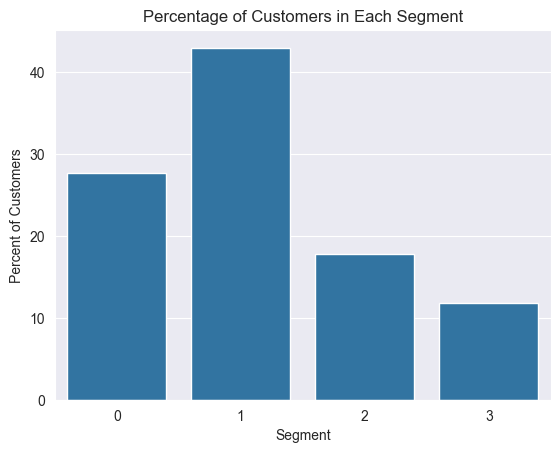

In [26]:
segment_counts = customer_report['Segment'].value_counts(normalize=True) * 100
percent_df = segment_counts.reset_index()
percent_df.columns = ['Segment', 'Percent']

sns.barplot(x='Segment', y='Percent', data=percent_df)
plt.title('Percentage of Customers in Each Segment')
plt.xlabel('Segment')
plt.ylabel('Percent of Customers')
plt.show()

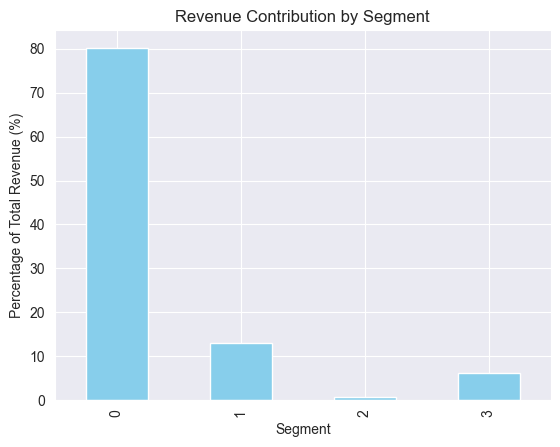

In [27]:
segment_profile['RevenuePct'].plot(kind='bar', color='skyblue')
plt.title('Revenue Contribution by Segment')
plt.xlabel('Segment')
plt.ylabel('Percentage of Total Revenue (%)')
plt.show()

The algorithm has put customers into 4 groups based on their activities. 
- Segment 0: Premier Clients (Best Customers)
This segment comprises customers with the highest average transaction amounts and account balances, contributing over 80% of revenue. They represent the bank’s wealthiest and most engaged clients, often targeted with personalized wealth management, premium products, and exclusive service offerings to enhance retention and deepen relationships.
- Segment 1:'Mass Market Customers' (core banking base). This large segment features moderate average transaction values and balances. They form the consistent, dependable base for the bank, with steady but not exceptional engagement. These customers often benefit from mass-market offerings, loyalty programs, and upsell campaigns aimed at moving them toward higher value segments.
- Segment 2: Dormant / Low-Value Customers (At-Risk or Uncertain Group). The smallest segment with the lowest average transaction and balance profiles, contributing minimally to revenue. These customers may be inactive, disengaged, or infrequent users. Strategies for this segment often involve cost-effective digital outreach, efforts to reactivate or cross-sell, or decisions about the long-term viability of continuing these accounts.
- Segment 3: Transactional Customers (Emerging or Opportunity Segment)
This smaller group exhibits moderate transaction values but very low average balances. They may be younger or have recently opened accounts and engage mostly in transactional banking. The bank can focus on this group with entry-level savings products, financial education, and incentives to build balances and loyalty.

## Relationship between demogrpahics and segments

After classifying customers into different segments, the next step is to explore whether there are significant relationship between customers' demographics and segments for designing more tailored business strategies to each customer.

In [28]:
# Merge demographics into aggregated customer data with cluster labels
customer_demo = df[['CustomerID', 'CustGender', 'Top15Location', 'Age']].drop_duplicates()
customer_with_demo = pd.merge(customer_report, customer_demo, on='CustomerID', how='left')

In [29]:
# Function to perform chi-square test and print results
def chi_square_test(col_name):
    contingency_table = pd.crosstab(customer_with_demo['Segment'], customer_with_demo[col_name])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    print(f"Chi-square test for Segment vs. {col_name}:")
    print(f"Chi2 statistic = {chi2:.4f}, p-value = {p:.4e}, degrees of freedom = {dof}")
    if p < 0.05:
        print("=> Significant association detected.\n")
    else:
        print("=> No significant association detected.\n")

In [30]:
# Test for gender
chi_square_test('CustGender')

Chi-square test for Segment vs. CustGender:
Chi2 statistic = 4906.7465, p-value = 0.0000e+00, degrees of freedom = 3
=> Significant association detected.


The Chi-square result  indicates that gender distribution differs substantially across the identified segments, supporting the use of gender-specific strategies or messaging when targeting customers in different groups.

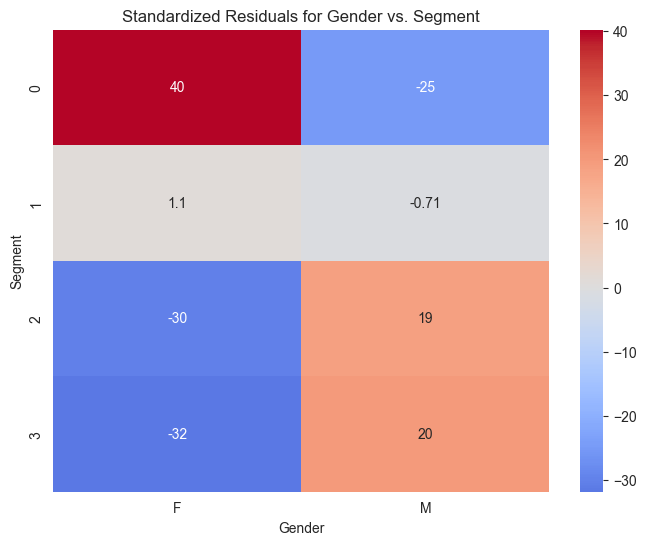

In [31]:
# Create observed contingency table
contingency = pd.crosstab(customer_with_demo['Segment'], customer_with_demo['CustGender'])
chi2, p, dof, expected = chi2_contingency(contingency)

# Calculate standardized residuals
residuals = (contingency - expected) / np.sqrt(expected)

# Plot heatmap of standardized residuals
plt.figure(figsize=(8, 6))
sns.heatmap(residuals, annot=True, cmap='coolwarm', center=0)
plt.title('Standardized Residuals for Gender vs. Segment')
plt.xlabel('Gender')
plt.ylabel('Segment')
plt.show()

Segment 0 (Premier Clients) contains significantly more females than expected and fewer males. Conversely, Segments 2 and 3 have notably more males and fewer females. Segment 1 shows no meaningful gender bias. These findings highlight strong gender-segment relationships, indicating that gender is a major driver of customer segment assignment in this dataset. Segment 0 strategies may focus on female-oriented outreach, while Segments 2 and 3 might consider the preferences and behavior of a predominantly male clientele

In [32]:
# For location, due to high cardinality, test top N locations grouped, or reduce categories
chi_square_test('Top15Location')

Chi-square test for Segment vs. Top15Location:
Chi2 statistic = 12153.0867, p-value = 0.0000e+00, degrees of freedom = 45
=> Significant association detected.


Similarly, location distribution differs substantially across the identified segments.

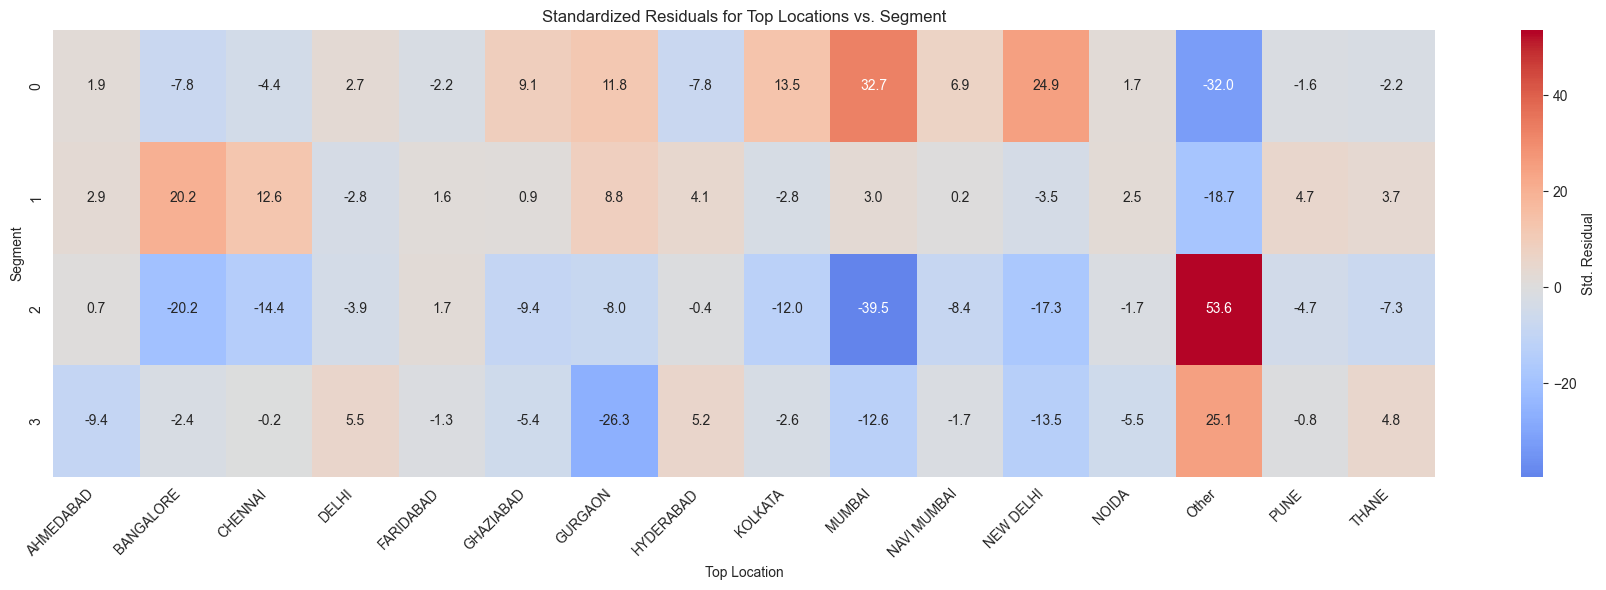

In [33]:
# Build observed contingency table for Segment vs TopLocation
contingency_loc = pd.crosstab(customer_with_demo['Segment'], customer_with_demo['Top15Location'])

# Chi-square test and expected counts
chi2, p, dof, expected_loc = chi2_contingency(contingency_loc)

# Calculate standardized residuals
residuals_loc = (contingency_loc - expected_loc) / np.sqrt(expected_loc)

# Plot heatmap of standardized residuals
plt.figure(figsize=(18, 6))
sns.heatmap(residuals_loc, annot=True, fmt=".1f", cmap="coolwarm", center=0, cbar_kws={'label': 'Std. Residual'})
plt.title("Standardized Residuals for Top Locations vs. Segment")
plt.xlabel("Top Location")
plt.ylabel("Segment")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The most extreme positive/negative residuals highlight which segments are especially concentrated or scarce in each location. Segment 0 is strongly overrepresented in Mumbai and New Delhi (residuals ≈ +32.7 and +24.9). This suggests these regions are dominant for customers assigned to Segment 0, likely “Premier” or “VIP” clients. By constrast, Segment 0 is underrepresented in Bangalore, Hyderabad, and 'Other' locations (residuals ≈ -7.8, -7.8, and -32.-), indicating fewer Segment 0 clients than expected in these locations. Geographic targeting should be tailored: VIP campaigns are best focused in Mumbai and New Delhi clusters; Segment 2 retention efforts should prioritize 'Other" locations'.

In [65]:
groups = [customer_with_demo[customer_with_demo['Segment']==seg]['Age'] for seg in customer_with_demo['Segment'].unique()]
stat, p = kruskal(*groups)
print("Kruskal-Wallis H-statistic:", stat)
print("p-value:", p)

Kruskal-Wallis H-statistic: 56855.13671474575
p-value: 0.0


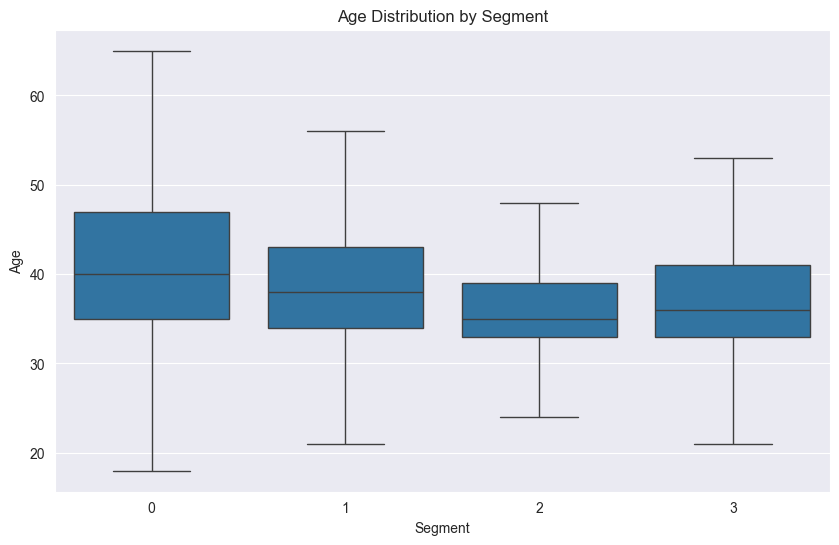

In [35]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Segment', y='Age', data=customer_with_demo, showfliers=False)
plt.title('Age Distribution by Segment')
plt.xlabel('Segment')
plt.ylabel('Age')
plt.show()

The boxplot illustrates the distribution of customer ages across the four identified segments. Each box displays the median age, the interquartile range (IQR), and the spread of ages within each segment, excluding extreme outliers for clarity.
The visual differences among the segments align with the Kruskal-Wallis statistical test results, indicating significant variation in age distributions between at least one pair of segments. Notably, Segment 2 has a higher median age and wider age spread, suggesting this group comprises relatively older customers compared to others. The other segments show somewhat overlapping age ranges but with different central tendencies.

## Feature Engineering

In [36]:
# Create age bins
bins = [18, 30, 40, 50, 60, 70, 80, 90]
labels = ['<30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90']

customer_with_demo['AgeBin'] = pd.cut(customer_with_demo['Age'], bins=bins, labels=labels, right=False)

In [37]:
# Interaction between Age and CustGender
customer_with_demo['AgeBin_Gender'] = customer_with_demo['AgeBin'].astype(str) + '_' + customer_with_demo['CustGender']

In [38]:
# Interaction between Age and Location
customer_with_demo['AgeBin_Location'] = customer_with_demo['Age'].astype(str) + '_' + customer_with_demo['Top15Location']

In [39]:
# Interaction between Gender and Location
customer_with_demo['Gender_Location'] = customer_with_demo['CustGender'].astype(str) + '_' + customer_with_demo['Top15Location']

In [40]:
# Interaction between Age, Location and CustGender
customer_with_demo['AgeBin_Location_Gender'] = customer_with_demo['Age'].astype(str) + '_' + customer_with_demo['Top15Location'] + '_' + customer_with_demo['CustGender']

In [41]:
# Metro GDP (billion INR) and population (lakhs) data, abbreviated for brevity
city_gdp_pop = {
    'DELHI NCR': {'gdp': 15375.37, 'pop': 320.66},
    'MUMBAI': {'gdp': 13417.15, 'pop': 234.87},
    'BENGALURU': {'gdp': 9285.52, 'pop': 131.93},
    'CHENNAI': {'gdp': 7560.56, 'pop': 117.99},
    'HYDERABAD': {'gdp': 6613.10, 'pop': 105.34},
    'KOLKATA': {'gdp': 6212.51, 'pop': 164.69},
    'AHMEDABAD': {'gdp': 5356.51, 'pop': 84.5},
    'PUNE': {'gdp': 4181.04, 'pop': 69.87},
    'SURAT': {'gdp': 3497.27, 'pop': 77.84},
    'JAIPUR': {'gdp': 1497.67, 'pop': 41.07},
    'LUCKNOW': {'gdp': 902.22, 'pop': 38.54},
    # Add as needed...
}

def city_lookup(x):
    lookup = {
        'NEW DELHI': 'DELHI NCR',
        'DELHI': 'DELHI NCR',
        'NOIDA': 'DELHI NCR',
        'GURGAON': 'DELHI NCR',
        'FARIDABAD': 'DELHI NCR',
        'GHAZIABAD': 'DELHI NCR',
        'THANE': 'MUMBAI',
        'NAVI MUMBAI': 'MUMBAI'
    }
    x = x.upper()
    return lookup.get(x, x)

india_gdp_per_head = 269500000000000 / 1420000000  # ≈ 189789 INR

def get_gdp_per_head(city):
    if city == 'Other':
        return india_gdp_per_head
    city_key = city_lookup(city)
    if city_key in city_gdp_pop:
        gdp = city_gdp_pop[city_key]['gdp'] * 1e9
        pop = city_gdp_pop[city_key]['pop'] * 1e5
        return gdp / pop if pop > 0 else None
    return india_gdp_per_head

customer_with_demo['LocationGDPperHead'] = customer_with_demo['Top15Location'].apply(get_gdp_per_head)

## Predicting customers' demographics with Light GBM

In [42]:
# Prepare features and target
X = customer_with_demo[['CustGender', 'Top15Location', 'Age', 'AgeBin', 'AgeBin_Gender', 'Gender_Location', 'AgeBin_Location_Gender', 'LocationGDPperHead']]
y = customer_with_demo['Segment'] == 0

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
categorical_features = ['CustGender', 'Top15Location', 'AgeBin', 'AgeBin_Gender', 'Gender_Location', 'AgeBin_Location_Gender']
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')
cat_feat_indices = [X_train.columns.get_loc(col) for col in categorical_features]

In [46]:
numerical_features = ['Age', 'LocationGDPperHead']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val_scaled[numerical_features] = scaler.transform(X_val[numerical_features])

In [47]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_feat_indices)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_feat_indices, reference=train_data)

In [48]:
# Train LightGBM classifier
baseline_model = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=1000,
    random_state=42
)

In [49]:
# Fit with early stopping + logging (LightGBM 4.x uses callbacks)
baseline_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 238653, number of negative: 547307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1335
[LightGBM] [Info] Number of data points in the train set: 785960, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.303645 -> initscore=-0.829999
[LightGBM] [Info] Start training from score -0.829999
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.589001
[100]	valid_0's binary_logloss: 0.588943
[150]	valid_0's binary_logloss: 0.588919
[200]	valid_0's binary_log

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,1000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [50]:
# Predict and evaluate
baseline_proba = baseline_model.predict_proba(X_val)
baseline_y_pred = np.argmax(baseline_proba, axis=1)

In [51]:
print("Baseline Macro F1:", f1_score(y_val, baseline_y_pred, average='macro'))
print(classification_report(y_val, baseline_y_pred))

Baseline Macro F1: 0.486721645704192
              precision    recall  f1-score   support

       False       0.71      0.97      0.82    136689
        True       0.56      0.09      0.15     59802

    accuracy                           0.70    196491
   macro avg       0.63      0.53      0.49    196491
weighted avg       0.66      0.70      0.62    196491


Building on this baseline model, the next step is to add class weights to the model to enhance its performance in predicting class.

In [52]:
classes, counts = np.unique(y_train, return_counts=True)
weights = {int(c): len(y_train)/(len(classes)*cnt) for c, cnt in zip(classes, counts)}

In [53]:
# Train LightGBM classifier
added_cw_model = lgb.LGBMClassifier(
    class_weight=weights,
    objective='binary',
    n_estimators=1000,
    random_state=42
)

In [54]:
# Fit with early stopping + logging (LightGBM 4.x uses callbacks)
added_cw_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 238653, number of negative: 547307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1335
[LightGBM] [Info] Number of data points in the train set: 785960, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.662544
[100]	valid_0's binary_logloss: 0.662418
[150]	valid_0's binary_logloss: 0.662381
[200]	valid_0's binary_loglo

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,1000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,"{0: np.float64(0.7180248014368535), 1: np.float64(1.6466585377095615)}"
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [55]:
# Predict and evaluate
added_cw_model_proba = added_cw_model.predict_proba(X_val)
added_cw_model_y_pred = np.argmax(added_cw_model_proba, axis=1)

In [56]:
print("After adding class weight Macro F1:", f1_score(y_val, added_cw_model_y_pred, average='macro'))
print(classification_report(y_val, added_cw_model_y_pred))

After adding class weight Macro F1: 0.5833039266740545
              precision    recall  f1-score   support

       False       0.77      0.63      0.69    136689
        True       0.40      0.57      0.47     59802

    accuracy                           0.61    196491
   macro avg       0.59      0.60      0.58    196491
weighted avg       0.66      0.61      0.63    196491


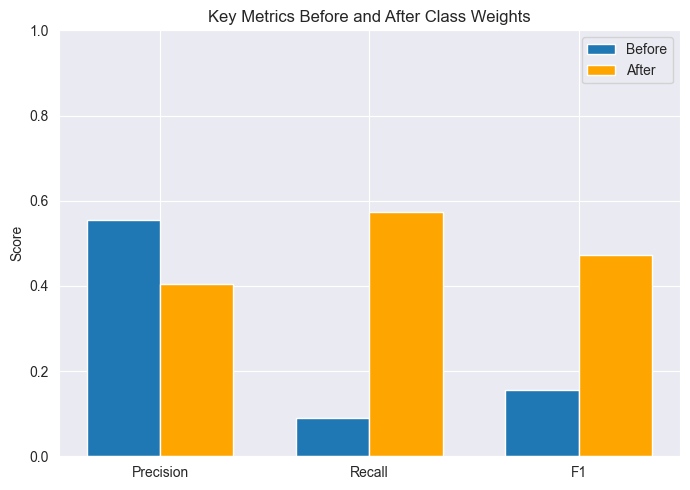

In [68]:
metrics_before = [
    precision_score(y_val, baseline_y_pred),
    recall_score(y_val, baseline_y_pred),
    f1_score(y_val, baseline_y_pred)
]
metrics_after = [
    precision_score(y_val, added_cw_model_y_pred),
    recall_score(y_val, added_cw_model_y_pred),
    f1_score(y_val, added_cw_model_y_pred)
]
metrics = ['Precision', 'Recall', 'F1']

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(7,5))
ax.bar(x - width/2, metrics_before, width, label='Before')
ax.bar(x + width/2, metrics_after, width, label='After', color='orange')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.set_title('Key Metrics Before and After Class Weights')
ax.legend()
plt.tight_layout()
plt.show()

Adding class weights shifted the model from being overly conservative (high precision, very low recall) to much more balanced. Recall increased over five-fold, so the model now catches many more target cases, even though it sacrifices some precision. The net effect is a higher F1-score—better for applications where missing positives is more costly than producing some false alarms.

## Conclusion

This Bank Customer Segmentation project demonstrates how data-driven clustering can yield actionable insights for financial institutions seeking to optimize customer management and strategy. Using K-Means on aggregated transaction data, customers were classified into four segments ranging from Premier Clients to Dormant/At-Risk groups. Analysis showed that segment membership is significantly associated with key demographics such as gender, location, and age, underpinning the business case for tailored marketing and retention campaigns. Enhancements like class weighting in supervised prediction models further improved identification of top-value clients, balancing precision with recall. Overall, this approach enables banks to prioritize high-value segments, design targeted engagement efforts, and allocate resources where they drive the greatest revenue and retention impact.